# Determine Diversion Flows for a hypothetical Scenario

  Created on  1/12/2021                                                      
  Designed for => Python 3.7.6, adapted for Jupyter notebook                
  @author: Karina Y Gutierrez-Jurado                                        
  Email: karina.gutierrez@flinders.edu.au                                                                        
  Last: modified ____________                                               

#### Script looks at flow from station 401211A for the period of data 1968 to 2021 and determines:
    
    1) How many years during the period of record, can we divert the 100GL
    target while complying with hypothetical flow thresholds and diversion
    rules for this location
    
    2) How many days each year is there a flow excedent where water can be 
       diverted

### Import Packages

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

### Specify the path to the data file and create an output folder to save the figures

In [2]:
folder_path = os.getcwd() 
flow_file = "401211a_historical.csv"

# Change to the directory where the .dat file is located
os.chdir(folder_path)
fig_dir = 'figures'

# Create a folder to store the figures
if not os.path.exists("figures"):
    print("create figures folder")
    os.mkdir(fig_dir)

### Read in the .csv file and create a dataframe

In [3]:
df = pd.read_csv(flow_file, index_col=0, header = 2, parse_dates=True)
df = df.iloc[2:]
df.dropna(how="all", inplace=True)
df["Discharge (ML/Day)"] = df["Discharge (ML/Day)"].astype(float)

### Specify the flow threshold and diversion rules to determine when and how much water can be diverted

We have two conditions we need to follow:

    We can't divert water if the flow is under 500 MG (ie. flow threshold)
    If flow is above 500 MG we can only divert half of the excedent (ie. [flow - flow threshold] * 0.5)

In [4]:
#Flow threshold (ML) under which NO water can be diverted 
flow_threshold = 500

# Diversion of flow allowed above threshold
diversion_rule = 0.5 

conditions = (df["Discharge (ML/Day)"] <= flow_threshold, 
              df["Discharge (ML/Day)"] > flow_threshold) 

div_values = (0, (df["Discharge (ML/Day)"] - flow_threshold) * diversion_rule)

#Create a new column with the calculated diversion values using the conditions above
df['Diversion (ML/Day)'] = np.select(conditions, div_values)

### Resample the data to obtain yearly values of the total flows that can be diverted

In [ ]:
df_yearly = df.resample('Y').sum()
              
# Rename columns units to ML/year
df_yearly.rename(columns={'Discharge (ML/Day)':"Discharge (ML/Year)",
                          "Diversion (ML/Day)" :'Diversion (ML/Year)'},
                 inplace=True)

Now we can determine how many years for this historical dataset we could have complied with the diversion target

In [11]:
diversion_target = 100 #(GL)

conditions = ((df_yearly["Discharge (ML/Year)"]/1000) < flow_threshold,
              (df_yearly["Diversion (ML/Year)"]/1000) >= diversion_target) 

div_values = ("no", "yes")

# Create a column which tell us if the diversion target was met or not
df_yearly['target_met'] = (np.select(conditions, div_values))

# Calculate how many years do we meet the diversion target during these period of record
diversion_years = df_yearly['target_met'].value_counts()['yes']

# BONUS QUESTION: How many days during each year can we divert water (flows are above threshold)
no_divdays_year = (df["Diversion (ML/Day)" ] > 0).resample('Y').sum().astype(int)



### The number of years from 1968 to 2021 that the diversion target is met is

In [12]:
print ((diversion_years))

33


We can see how many days each year had flows above the diversion threshold

In [14]:
print(no_divdays_year)

Date
1968-12-31    103
1969-12-31    326
1970-12-31    312
1971-12-31    365
1972-12-31    348
1973-12-31    337
1974-12-31    365
1975-12-31    365
1976-12-31    336
1977-12-31    264
1978-12-31      2
1979-12-31      7
1980-12-31     16
1981-12-31     77
1982-12-31    142
1983-12-31    109
1984-12-31      5
1985-12-31     28
1986-12-31     69
1987-12-31     18
1988-12-31    139
1989-12-31     55
1990-12-31    201
1991-12-31    228
1992-12-31    211
1993-12-31    277
1994-12-31    327
1995-12-31    126
1996-12-31    165
1997-12-31    358
1998-12-31    212
1999-12-31    141
2000-12-31    126
2001-12-31     83
2002-12-31    361
2003-12-31    174
2004-12-31    198
2005-12-31    128
2006-12-31    197
2007-12-31    167
2008-12-31     32
2009-12-31     45
2010-12-31     45
2011-12-31     33
2012-12-31    105
2013-12-31    283
2014-12-31    261
2015-12-31    359
2016-12-31    144
2017-12-31     52
2018-12-31    213
2019-12-31    289
2020-12-31    114
2021-12-31     31
Freq: A-DEC, Name: Dive

### Create a couple of figures to sumarize the data

In [12]:
# Set up plotting specs
plt.rc("axes", linewidth=0.5)
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'legend.labelspacing':0.25})
plt.matplotlib.rc('font', **{'sans-serif' : 'Arial','family' : 'sans-serif'}) 
plt.rcParams['lines.linewidth'] = 1.0

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


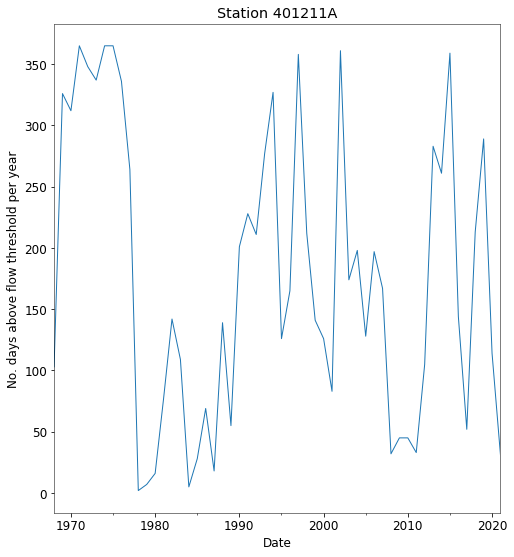

In [13]:
#----------Fig 1 Number of days per year where flow is above threshold

fig = plt.figure(figsize=(8, 9))
ax = fig.add_subplot(111)
plot1 = no_divdays_year.plot(ax=ax)

ax.set_xlabel('Date')
ax.set_ylabel('No. days above flow threshold per year')
ax.set_title("Station 401211A")  
plt.savefig(os.path.join(fig_dir, "Total_days_above_threshold(Y)" + '.png'),
            bbox_inches = "tight", dpi=300)

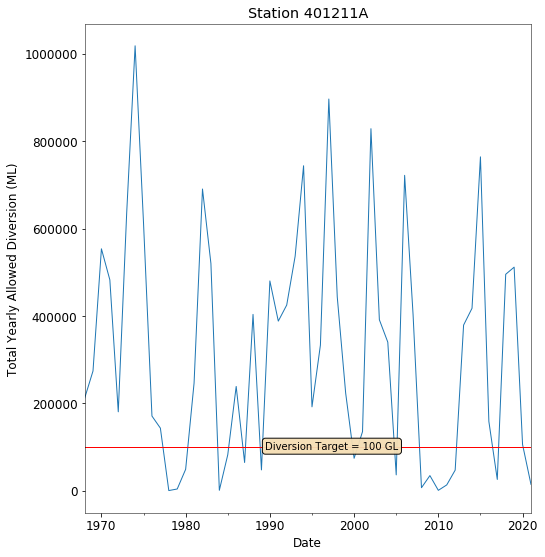

In [15]:
#----------Fig 2 Years where the total amount of allowed diverted flows exceed 
#----------      the diversion target of 100 GL
fig = plt.figure(figsize=(8, 9))
ax = fig.add_subplot(111)
plot1 = df_yearly["Diversion (ML/Year)"].plot(ax=ax)

plt.axhline(y=(diversion_target*1000), color='r', linestyle='-')

props = dict(boxstyle='round', facecolor='wheat', alpha=0.95)

plt.text(0.405, 0.13, "Diversion Target = 100 GL", transform=ax.transAxes,
         fontsize=10,  bbox=props)

ax.set_xlabel('Date')
ax.set_ylabel('Total Yearly Allowed Diversion (ML)')
ax.set_title("Station 401211A")  
plt.savefig(os.path.join(fig_dir, "Yearly_allowed_diversion(MG)" + '.png'),
            bbox_inches = "tight", dpi=300)
